In [1]:
import logging
import ConfigParser
import csv
import functools
import getpass
import koji
import datetime
import time
from requests.exceptions import ConnectionError
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression

#NEVER RUN THIS AGAIN UNLESS NEEDED (TAKES FOREVER!)

# class Brew():

#     def __init__(self):
#         self.client = koji.ClientSession('http://brewhub.engineering.redhat.com/brewhub')
    
#     def retry(timeout=240, interval=60, wait_on=Exception):
#         """ A decorator that allows to retry a section of code...
#         ...until success or timeout.
#         """
#         def wrapper(function):
#             @functools.wraps(function)
#             def inner(*args, **kwargs):
#                 start = time.time()
#                 while True:
#                     if (time.time() - start) >= timeout:
#                         raise  # This re-raises the last exception.
#                     try:
#                         return function(*args, **kwargs)
#                     except wait_on as e:
#                         print("Exception %r raised from %r.  Retry in %rs" % (
#                             e, function, interval))
#                         time.sleep(interval)
#             return inner
#         return wrapper

#     def iterator(self, start_date, end_date):
#         current_date = start_date
#         delta = datetime.timedelta(days=1)
#         while current_date < end_date:
#             yield current_date
#             current_date += delta
            
#     @retry(wait_on=ConnectionError)
#     def find_data(self):
#         # fetch builds from Teiid
#         docs = []
#         start_date = datetime.datetime.strptime(
#                 '2015-01-01', '%Y-%m-%d').date()
#         end_date = datetime.date.today()
#         previous_date = start_date
#         count = 0
#         for date in self.iterator(start_date, end_date):
#             builds = self.client.listBuilds(
#                     completeAfter=str(previous_date), completeBefore=str(date))
#             docs.extend(builds)
#             previous_date = date
#             count += 1
#             if count%5 == 0:
#                 time.sleep(1)

#         return docs
    
#     def copy_data_in_csv(self, docs):
#         # This is just faster in terms of retrieval. The calculation of diff and removal of None 
#         # would be easier in dataframes.
#         print len(docs)
#         the_file = open("metric_data.csv", "w")
#         writer = csv.DictWriter(the_file, docs[0].keys())
#         writer.writeheader()
#         writer.writerows(docs)
#         the_file.close()        
    
# br = Brew()
# docs = br.find_data()
# br.copy_data_in_csv(docs)


170265


In [20]:
# Read data from csv to a dataframe
import pandas as pd
data_df = pd.read_csv("metric_data.csv")
# data_df

In [21]:
# Calculate the waiting time of a build
print "Total builds in data_df: ", len(data_df)
data_df['waiting_time(seconds)'] = (data_df.creation_ts - data_df.start_ts)
diff_df = data_df[['creation_ts','start_ts','waiting_time(seconds)']]

null_wait_data_df = data_df[pd.isnull(data_df['waiting_time(seconds)'])]
data_df = data_df[pd.notnull(data_df['waiting_time(seconds)'])]
print "Builds having NaN wait times: ", len(null_wait_data_df)
print "Builds left after removing NaN wait times: ", len(data_df)
# data_df

Total builds in data_df:  170265
Builds having NaN wait times:  60615
Builds left after removing NaN wait times:  109650


In [22]:
# Separate out the docker and non-docker builds because it looks like
# only docker builds have a lag
docker_builds = []
non_docker_builds = []
docker_builds = data_df[pd.notnull(data_df['extra'])].values.tolist()
non_docker_builds = data_df[pd.isnull(data_df['extra'])].values.tolist()
print "Docker builds (total): ",len(docker_builds)
print "Non-Docker builds (total): ", len(non_docker_builds)

Docker builds (total):  18663
Non-Docker builds (total):  90987


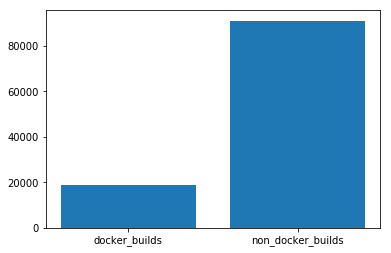

In [23]:
# Plotting the number of docker and non-docker builds
import numpy as np
import matplotlib.pyplot as plt
import datetime

D = {'docker_builds':len(docker_builds), 'non_docker_builds':len(non_docker_builds)}

plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())

plt.show()


In [24]:
# Builds having negative wait time
mystery_machine = []
for i in data_df.values.tolist():
    if (i[len(i)-1] == 0):
        continue
    elif(i[len(i)-1] > 0):
        continue
    else:
        mystery_machine.append(i)
print mystery_machine[0]

print "Number of builds having NEGATIVE wait time: ", len(mystery_machine)

['osbs-buildroot-docker', "{'image': {}}", '2016-05-31 08:50:39.278758', '2016-05-31 08:50:12', 50072, 497336, 2, 'git://pkgs.devel.redhat.com/rpms/osbs-buildroot-docker#2222014aef343ed4ab6a24439222e5e070b2af58', nan, '1.0', 1464684612.0, 3436, 'osbs', 'osbs-buildroot-docker-1.0-1.0.twaugh.31', '2016-05-31 12:40:13', 13306028, 1464698413.0, 0, 1464684639.27876, 'osbs-buildroot-docker', nan, 'DEFAULT', '1.0.twaugh.31', -13773.72124004364]
Number of builds having NEGATIVE wait time:  34


In [25]:
# Builds having waiting time >0 and ==0 and confirming that only
# docker builds have non-zero wait times.

print 'Total builds present after filtering those with NaN: ', len(data_df)

builds_nonzero_wait = data_df[data_df['waiting_time(seconds)']>0]
print "Total builds with non-zero wait time:                ", len(builds_nonzero_wait)
docker_builds_nonzero_wait = builds_nonzero_wait[pd.notnull(builds_nonzero_wait['extra'])].values.tolist()


builds_zero_wait = data_df[data_df['waiting_time(seconds)'] == 0.000]
print "Total builds with zero wait time:                    ", len(builds_zero_wait)
non_docker_builds_zero_wait = builds_zero_wait[pd.isnull(builds_zero_wait['extra'])].values.tolist()
print "Number of builds having NEGATIVE wait time:          ", len(mystery_machine)
print "=================================================================="

print "Total Docker builds with non-zero wait time:         ", len(docker_builds_nonzero_wait)
print "Total non_docker builds with zero wait time:         ", len(non_docker_builds_zero_wait)

Total builds present after filtering those with NaN:  109650
Total builds with non-zero wait time:                 18629
Total builds with zero wait time:                     90987
Number of builds having NEGATIVE wait time:           34
Total Docker builds with non-zero wait time:          18629
Total non_docker builds with zero wait time:          90987


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

data_df = data_df[data_df['waiting_time(seconds)']>=0]

# Pre-process the data to bring it in the suitable format
regression_df = data_df[['extra','state', 'creation_ts']]
regression_df['extra'] = regression_df['extra'].replace("{", 1, regex=True)
regression_df['extra'] = regression_df['extra'].fillna(0)
regression_df = regression_df.dropna()
wait_time_df = data_df[['waiting_time(seconds)']]

# regression_df['start_ts'] = (regression_df['start_ts'] - regression_df['start_ts'].mean())/regression_df['start_ts'].std(ddof=0)
regression_df['creation_ts'] = (regression_df['creation_ts'] - regression_df['creation_ts'].mean())/regression_df['creation_ts'].std(ddof=0)
wait_time_df['waiting_time(seconds)'] = (wait_time_df['waiting_time(seconds)'] - wait_time_df['waiting_time(seconds)'].mean())/wait_time_df['waiting_time(seconds)'].std(ddof=0)


# Split the data into testing and training set
X_train, X_test, y_train, y_test = train_test_split(regression_df, wait_time_df, test_size=0.33, random_state=42)


X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print len(X_train), len(y_train), len(X_test), len(y_test)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)

print('Variance score: %.2f' % regr.score(X_test, y_test))

print "=============================="
print regr.predict(X_test)
# print y_test


# regression_df['creation_ts'].apply(zscore)

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


73442 73442 36174 36174
('Coefficients: \n', array([[ 0.19072036, -0.0171591 ,  0.00116157]]))
Variance score: 0.01
[[ 0.16381523]
 [ 0.16373044]
 [-0.02733318]
 ..., 
 [-0.0280737 ]
 [-0.02986506]
 [-0.02857487]]


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(73442, 3) (73442, 1) (36174, 3) (36174, 1)


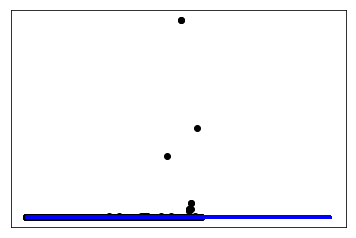

In [11]:
# Plot outputs (Worst graph ever!)
print X_train.shape, y_train.shape, X_test.shape, y_test.shape
plt.figure(1)
plt.scatter(X_test['creation_ts'], y_test,  color='black')
plt.plot(X_test, regr.predict(X_test), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [10]:
regression_df

,extra,state,start_ts,creation_ts
60615,0.0,2,-1.838051,-1.838039
60616,0.0,2,-1.838003,-1.837990
60617,0.0,2,-1.837960,-1.837948
60618,0.0,2,-1.838025,-1.838012
60619,0.0,2,-1.837977,-1.837965
60620,0.0,2,-1.838000,-1.837988
60621,0.0,2,-1.837978,-1.837965
60622,0.0,2,-1.837912,-1.837899
60623,0.0,1,-1.837757,-1.837745
60624,0.0,1,-1.837753,-1.837741


In [10]:
# This is bad news!
import statsmodels.formula.api as sm
result = sm.OLS( wait_time_df, regression_df ).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     waiting_time(seconds)   R-squared:                       0.005
Model:                               OLS   Adj. R-squared:                  0.005
Method:                    Least Squares   F-statistic:                     197.0
Date:                   Fri, 04 Aug 2017   Prob (F-statistic):          2.04e-127
Time:                           09:21:43   Log-Likelihood:            -1.5524e+05
No. Observations:                 109616   AIC:                         3.105e+05
Df Residuals:                     109613   BIC:                         3.105e+05
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
extra           0.1934      0.009     22.166      0.000       0.176       0.210
state          -0.0246      0.002     -9.932      0.000      -0.029      -0.020
creation_ts     0.0008      0.003      0.230      0.818      -0.006       0.007
==============================================================================
Omnibus:                   459876.575   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1066009850347.431
Skew:                         119.619   Prob(JB):                         0.00
Kurtosis:                   15278.520   Cond. No.                         4.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# Calculating derieved attributes
derieved_columns = data_df['waiting_time(seconds)'].groupby(pd.DatetimeIndex(data_df['creation_time']).normalize()).describe()
derieved_columns

,count,mean,std,min,25%,50%,75%,max
creation_time,,,,,,,,
2015-12-01,19.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2015-12-02,104.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2015-12-03,182.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2015-12-04,113.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2015-12-05,1.0,0.000000,NaN,0.0,0.000000,0.000000,0.000000,0.000000e+00
2015-12-06,40.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2015-12-07,196.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2015-12-08,275.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2015-12-09,116.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00


In [65]:
# # Calculating derieved attributes
# data_df["per_day"] = data_df['creation_time'].apply(lambda x: x[:10])
# data_frame = data_df.groupby(['per_day', 'waiting_time(seconds)'])
# test = data_frame.size().unstack()
# allHeaders = list(test.columns.values)
# totalWaitingTime = []
# minWaitingTime = []
# maxWaitingTime = []
# avgWaitingTime = []

# for i, (index, row) in enumerate(test.iterrows()):
#     series = test.loc[index, row]
#     count = 0
#     allHeadersindex = 0
#     minValue = 1000000000
#     maxValue = 0
#     numCounts = 0
#     for (item, value) in series.iteritems():
#         waiting_time = allHeaders[allHeadersindex]
#         if not math.isnan(item): 
#             numCounts += item
#             count += item * waiting_time
#             if waiting_time < minValue:
#                 minValue = waiting_time
#             if waiting_time > maxValue:
#                 maxValue = waiting_time
#         allHeadersindex += 1
#     avgTime = count/numCounts
#     totalWaitingTime.append(count)
#     minWaitingTime.append(minValue)
#     maxWaitingTime.append(maxValue)
#     avgWaitingTime.append(avgTime)

In [12]:
#     def copy_data_in_csv(self, docs): 
#         # copy builds in csv file
#         writer = csv.writer(csvfile, delimiter=',', fieldnames=[])
#         for build in docs:
#             print build
#             break
#         with open('test.csv', 'a') as csvfile:
#             if not build["creation_time"] or not build["start_time"]: 
#                 diff = None 
#             else: 
#                 if build["creation_time"].find(".") != -1:
#                     created_time = datetime.datetime.strptime(build["creation_time"], '%Y-%m-%d %H:%M:%S.%f')
#                 else:
#                     created_time = datetime.datetime.strptime(build["creation_time"], '%Y-%m-%d %H:%M:%S')

#                 if build["start_time"].find(".") != -1:
#                     start_time = datetime.datetime.strptime(build["start_time"], '%Y-%m-%d %H:%M:%S.%f')
#                 else:
#                     start_time = datetime.datetime.strptime(build["start_time"], '%Y-%m-%d %H:%M:%S')
#                 diff = str(created_time - start_time)

#         writer.writerow([build["package_name"], build["extra"], build["creation_time"], build["completion_time"], build["package_id"], build["build_id"], build["state"], build["source"], build["epoch"], build["version"], build["completion_ts"], build["owner_id"], build["owner_name"], build["nvr"], build["start_time"], build["creation_event_id"], build["start_ts"], build["volume_id"], build["creation_ts"], build["name"], build["task_id"], build["release"], diff])
